<div class="alert alert-primary" style="margin-top: 20px; padding: 20px; border-radius: 10px;background-color:  #6EC5FF; color: softblue;">

<h1><center>Customer Segmentation with Unsupervised Learning</center></h1>
    
</div>

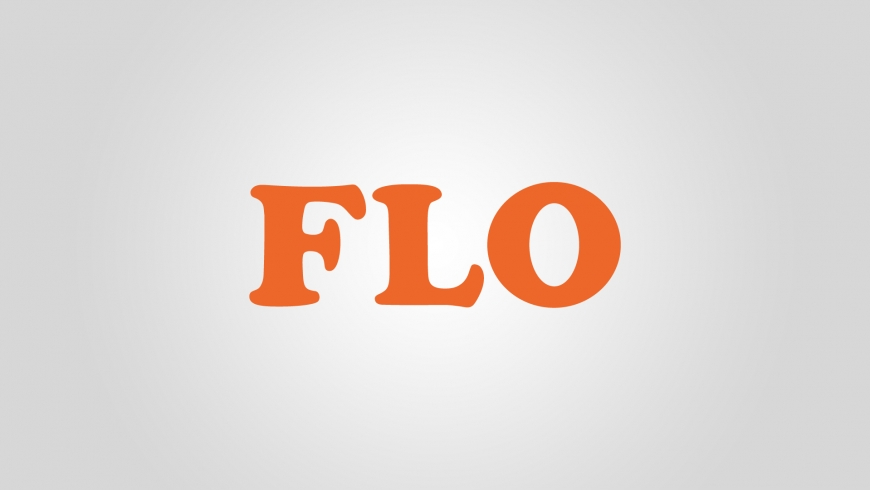

<h1 style="color: #074973; font-weight: bold; text-align: center;">Business Problem</h1>



<div style="background-color: #52B7FA;font-weight:bold; padding: 20px; border-radius: 10px; border: 1px solid #a7c195; color: #000000;">FLO wants to segment its customers and develop marketing strategies based on these segments. For this purpose, customer behaviors will be identified, and groups will be formed based on clustering of these behaviors. </div>

<h1 style="color: #074973; font-weight: bold;text-align: center">Dataset Story</h1>

<div style="background-color: #52B7FA;font-weight:bold; padding: 20px; border-radius: 10px; border: 1px solid #a7c195; color:#000000;"> The dataset consists of information obtained from past shopping behaviors of customers who made their last purchases as OmniChannel (shopping both online and offline) at FLO between 2020 and 2021. </div>

| Variable Name                        | Description                                                                              |
|--------------------------------------|------------------------------------------------------------------------------------------|
| master_id                            | Unique customer number                                                                   |
| order_channel                        | The platform channel used for the shopping (Android, iOS, Desktop, Mobile)               |
| last_order_channel                   | The channel used for the last purchase                                                   |
| first_order_date                     | The date of the customer's first purchase                                                |
| last_order_date                      | The date of the customer's last purchase                                                 |
| last_order_date_online               | The date of the customer's last online purchase                                          |
| last_order_date_offline              | The date of the customer's last offline purchase                                         |
| order_num_total_ever_online          | The total number of purchases made by the customer on the online platform                |
| order_num_total_ever_offline         | The total number of purchases made by the customer on the offline platform               |
| customer_value_total_ever_offline    | The total amount spent by the customer in offline purchases                              |
| customer_value_total_ever_online     | The total amount spent by the customer in online purchases                               |
| interested_in_categories_12          | The list of categories the customer has shopped in the last 12 months                    |


<h1 style="color: #074973; font-weight: bold;text-align:center">Importings</h1>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import warnings
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage, dendrogram
warnings.filterwarnings('ignore')


In [2]:
import sys
sys.path.append('/kaggle/input/utilities')
import utils

<h1 style="color: #074973; font-weight: bold;text-align:center">Load Data</h1>

In [3]:
df = pd.read_csv("/kaggle/input/flo-data/flo_data_20k.csv")

<h1 style="color: #074973; font-weight: bold;text-align:center">Preview and Preprocessing</h1>

In [4]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR]


In [5]:
utils.check_df(df)

########## Shape ##########
(19945, 12)
########## Types ##########
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### Duplicated Values #####################
0
########## Head ##########
                              master_id order_channel last_order_channel  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile   
2  69b69676-1a40-11ea-941b-000d3a38a36f   Android App      

In [6]:
# Check last order date and set analysis date 1 day later
df['last_order_date'].max()

'2021-05-30'

In [7]:
analysis_date = dt.datetime(2021, 6, 1)

In [8]:
df['tenure'] = (analysis_date - pd.to_datetime(df['first_order_date'])).dt.days
df['recency'] = (analysis_date - pd.to_datetime(df['last_order_date'])).dt.days
df['frequency'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']
df['monetary'] = df['customer_value_total_ever_online'] + df['customer_value_total_ever_offline']
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,tenure,recency,frequency,monetary
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],214,95,5.0,939.37
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",1574,105,21.0,2013.55
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",552,186,5.0,585.32
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",146,135,2.0,121.97
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],668,86,2.0,209.98


In [9]:
# Our purpose is to segmentate customers. We are not going to need some categorical variables. Let's drop them
model_df = df[["order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,4.0,1.0,139.99,799.38,95,214
1,19.0,2.0,159.97,1853.58,105,1574
2,3.0,2.0,189.97,395.35,186,552
3,1.0,1.0,39.99,81.98,135,146
4,1.0,1.0,49.99,159.99,86,668


In [10]:
_, num_cols, _ = utils.grab_col_names(model_df)

Observations: 19945
Variables: 6
cat_cols: 0
num_cols: 6
cat_but_car: 0
num_but_cat: 0


<h1 style="color: #074973; font-weight: bold;text-align:center">Numerical Variable Summary</h1>

order_num_total_ever_online
##########################################
count    19945.000000
mean         3.110855
std          4.225647
min          1.000000
5%           1.000000
10%          1.000000
20%          1.000000
30%          1.000000
40%          1.000000
50%          2.000000
60%          2.000000
70%          3.000000
80%          4.000000
90%          7.000000
95%         10.000000
99%         20.000000
max        200.000000
Name: order_num_total_ever_online, dtype: float64
##########################################


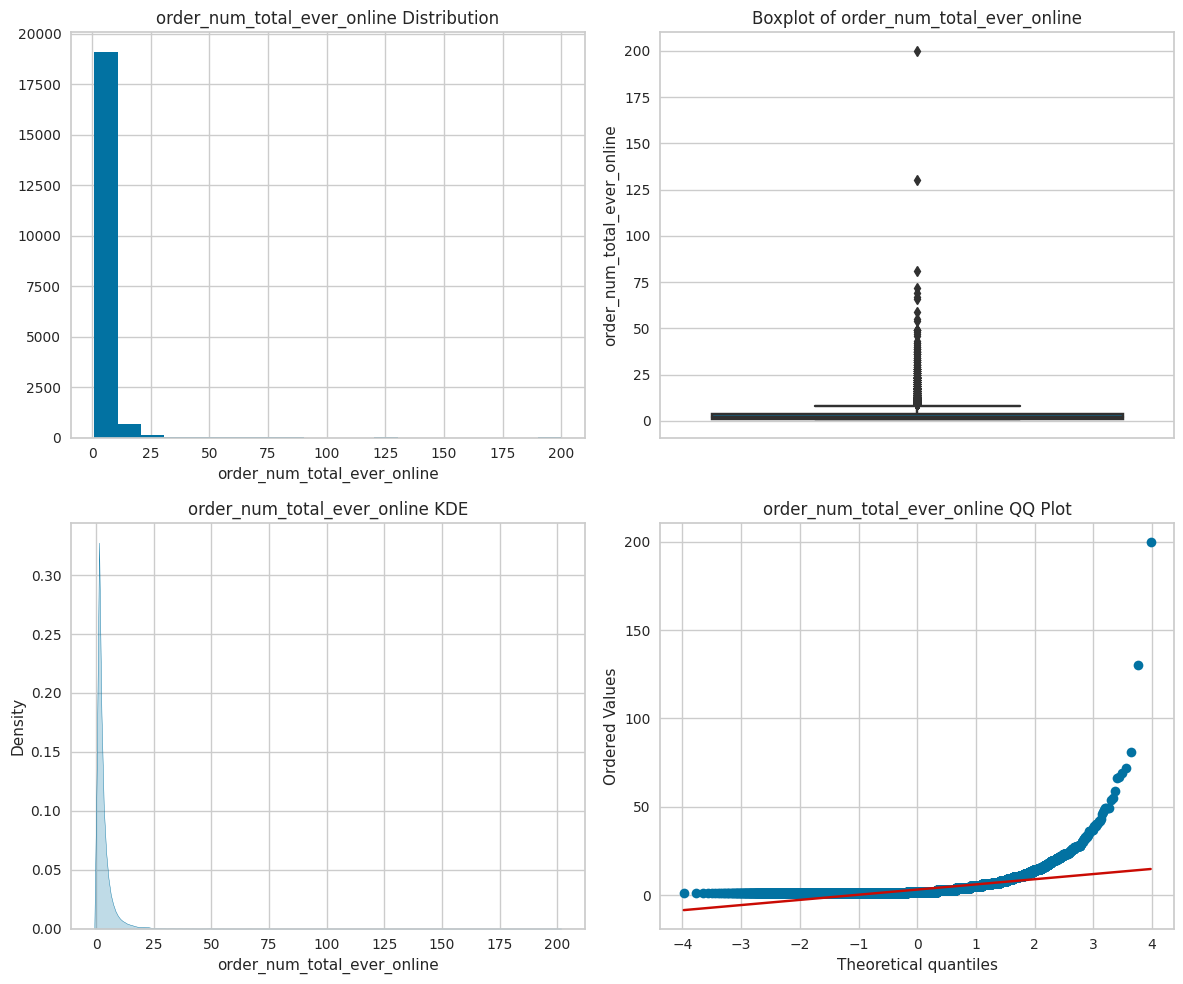

order_num_total_ever_offline
##########################################
count    19945.000000
mean         1.913913
std          2.062880
min          1.000000
5%           1.000000
10%          1.000000
20%          1.000000
30%          1.000000
40%          1.000000
50%          1.000000
60%          2.000000
70%          2.000000
80%          3.000000
90%          4.000000
95%          4.000000
99%          7.000000
max        109.000000
Name: order_num_total_ever_offline, dtype: float64
##########################################


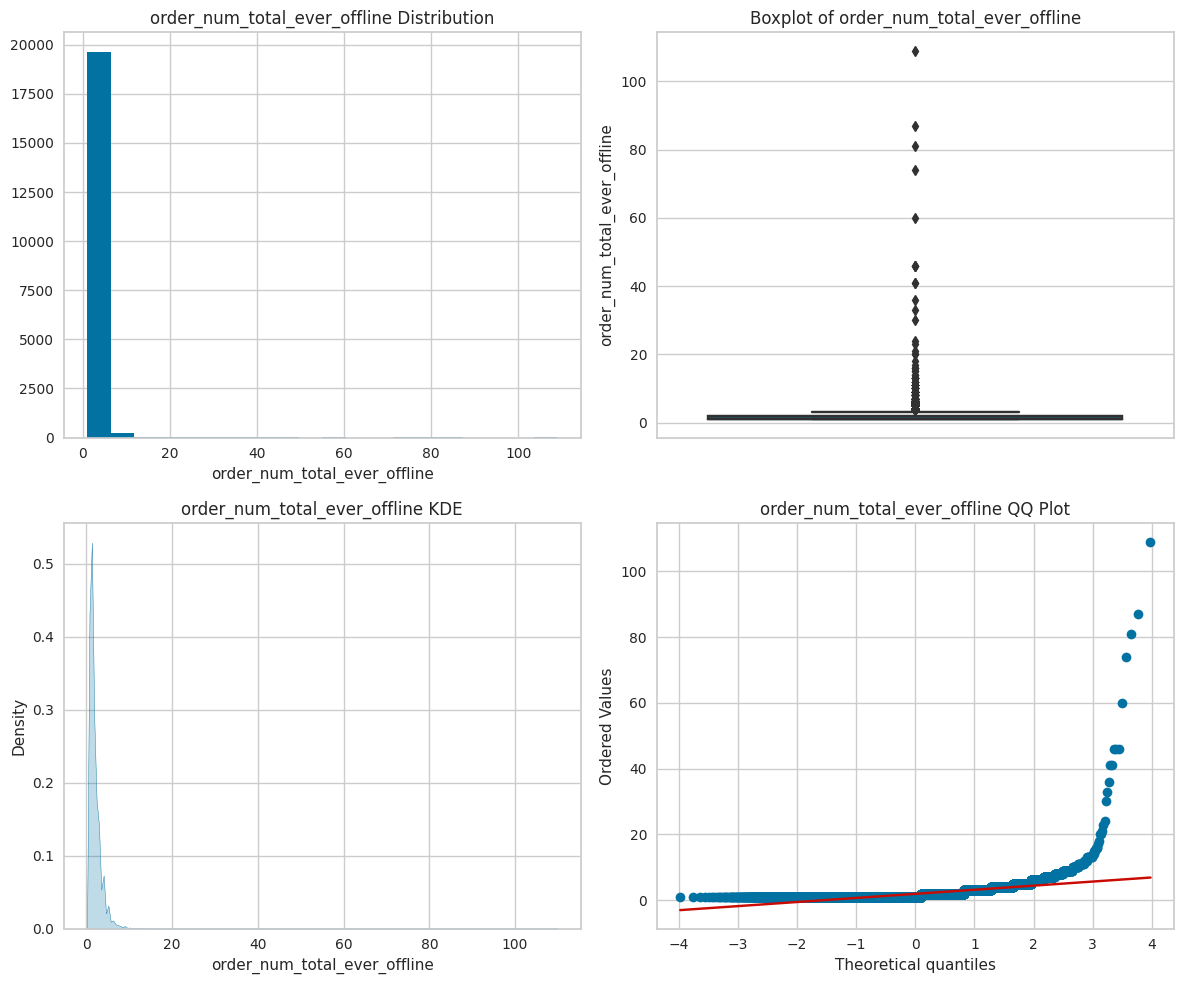

customer_value_total_ever_offline
##########################################
count    19945.000000
mean       253.922597
std        301.532853
min         10.000000
5%          39.990000
10%         59.990000
20%         89.980000
30%        110.480000
40%        140.230000
50%        179.980000
60%        220.860000
70%        281.868000
80%        365.058000
90%        519.950000
95%        694.222000
99%       1219.946800
max      18119.140000
Name: customer_value_total_ever_offline, dtype: float64
##########################################


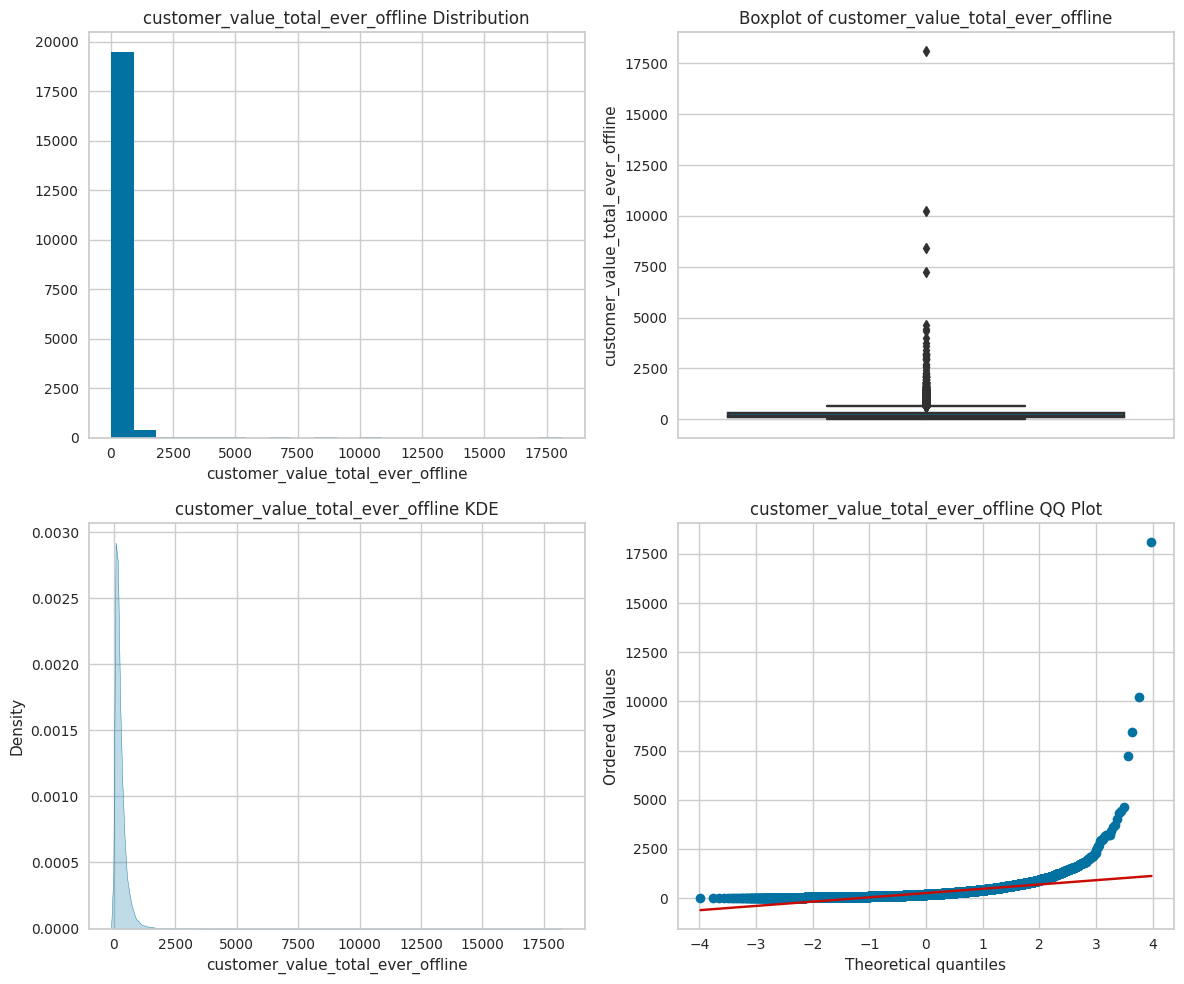

customer_value_total_ever_online
##########################################
count    19945.000000
mean       497.321690
std        832.601886
min         12.990000
5%          63.990000
10%         84.990000
20%        125.990000
30%        173.970000
40%        219.990000
50%        286.460000
60%        371.944000
70%        491.526000
80%        690.868000
90%       1082.036000
95%       1556.726000
99%       3143.810400
max      45220.130000
Name: customer_value_total_ever_online, dtype: float64
##########################################


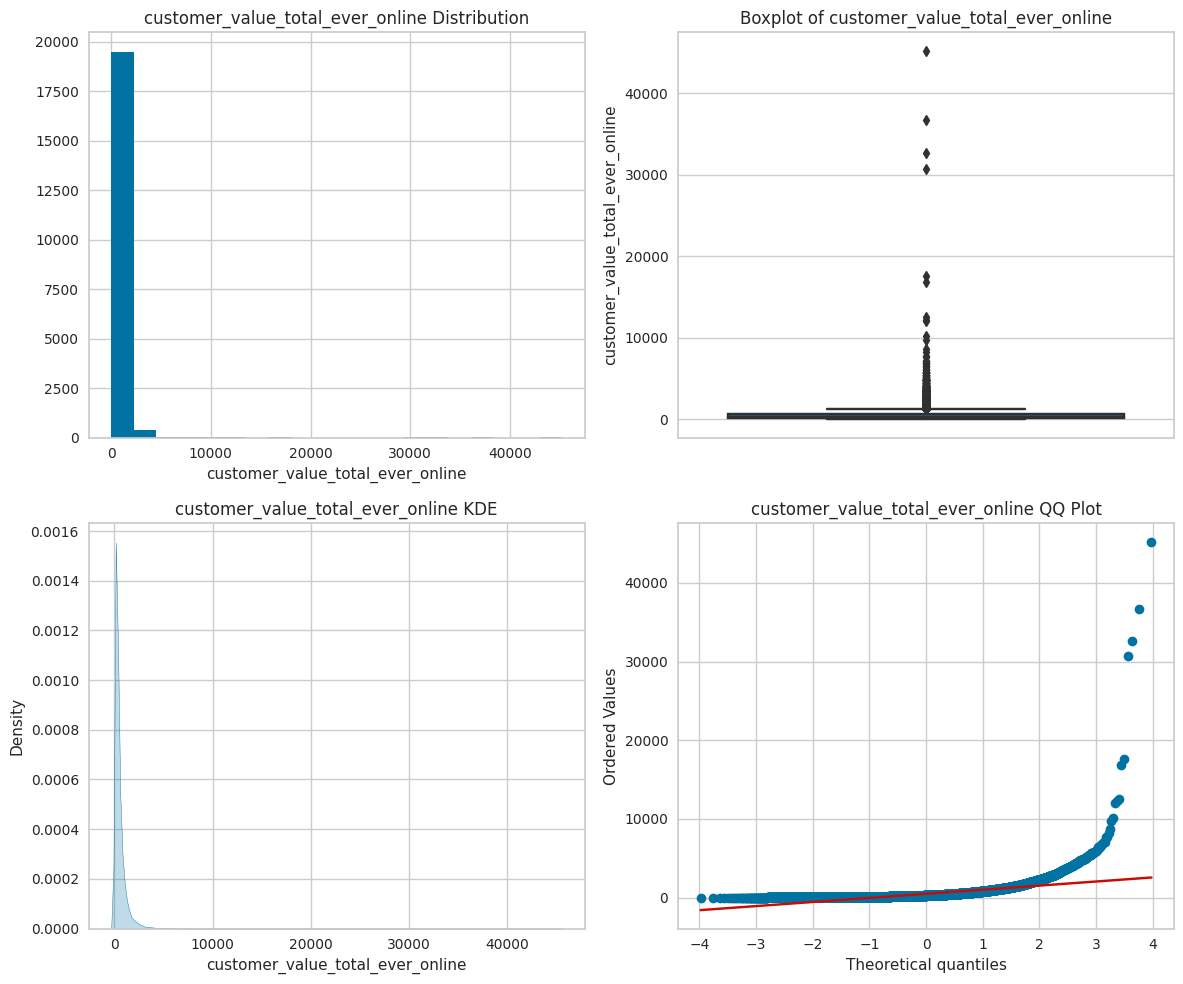

recency
##########################################
count    19945.000000
mean       134.458360
std        103.281149
min          2.000000
5%           9.000000
10%         16.000000
20%         33.000000
30%         56.000000
40%         83.000000
50%        111.000000
60%        145.000000
70%        186.000000
80%        232.000000
90%        308.000000
95%        335.000000
99%        360.000000
max        367.000000
Name: recency, dtype: float64
##########################################


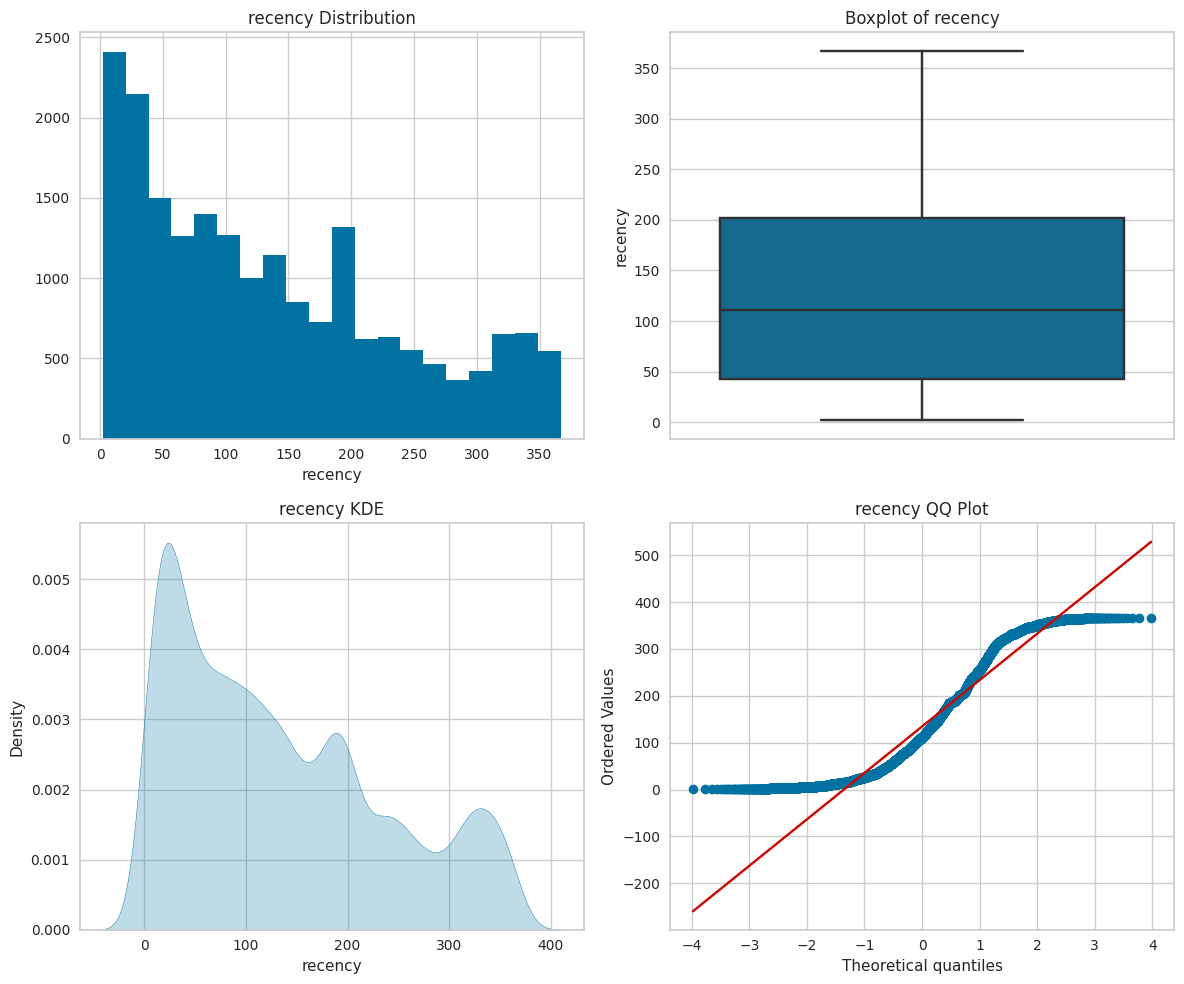

tenure
##########################################
count    19945.000000
mean       801.302833
std        523.396883
min          5.000000
5%         209.200000
10%        338.000000
20%        478.000000
30%        549.000000
40%        600.000000
50%        651.000000
60%        730.000000
70%        814.000000
80%        967.200000
90%       1544.000000
95%       2074.000000
99%       2605.000000
max       3060.000000
Name: tenure, dtype: float64
##########################################


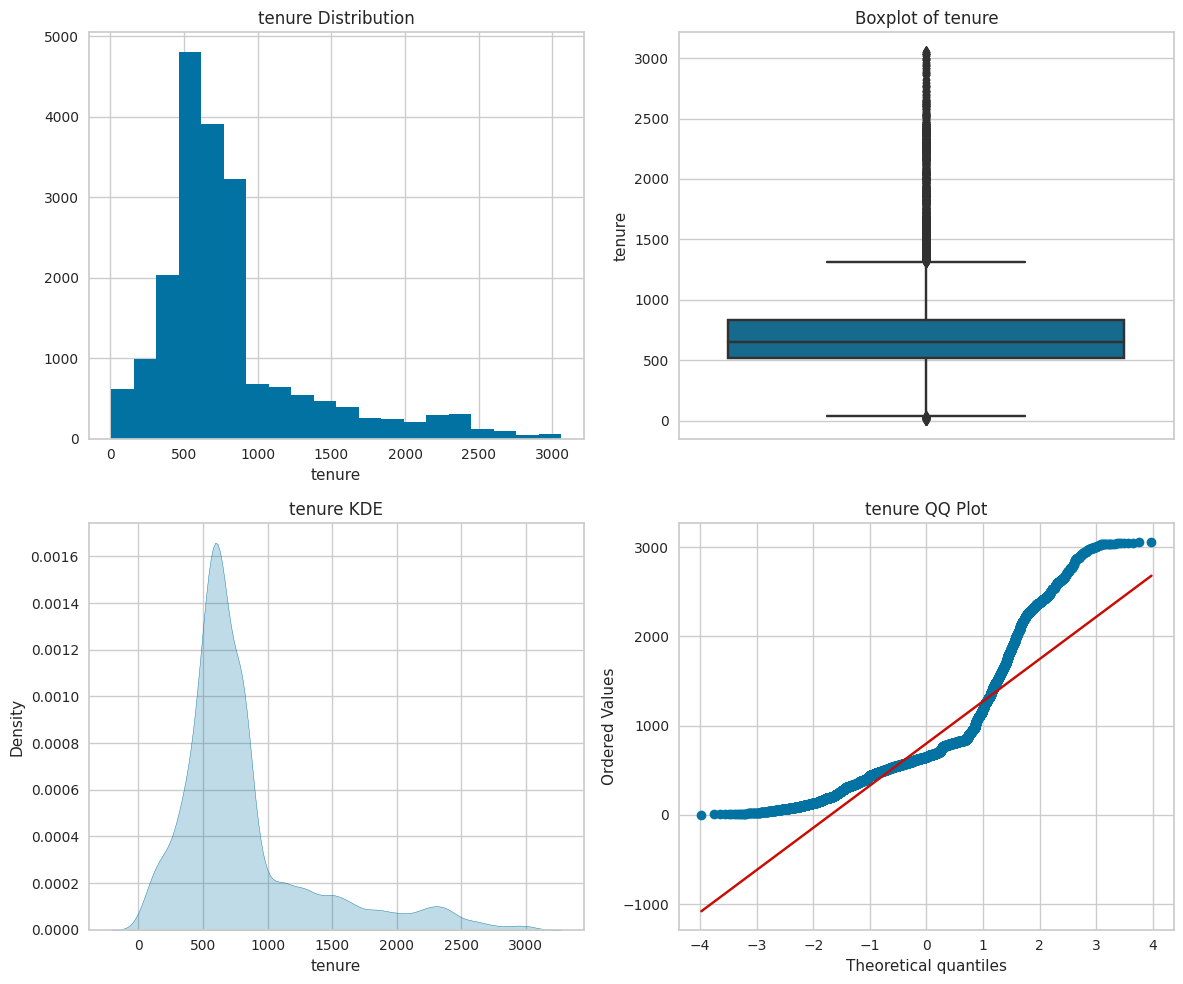

In [11]:
for col in num_cols:
    utils.num_summary(model_df,col, plot=True)

<h1 style="color: #074973; font-weight: bold;text-align:center">Log Transformation</h1>

In [12]:
for col in model_df.columns:
    model_df[col] = np.log1p(model_df[col])

<h1 style="color: #074973; font-weight: bold;text-align:center">Scaling</h1>

In [13]:
scaler = MinMaxScaler()
model_df_scaled = scaler.fit_transform(model_df)
model_df = pd.DataFrame(model_df_scaled, columns=model_df.columns)
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,0.198755,0.000000,0.344381,0.500774,0.720607,0.574022
1,0.499459,0.101181,0.362274,0.604762,0.741210,0.893422
2,0.150352,0.101181,0.385347,0.413806,0.859241,0.725548
3,0.000000,0.000000,0.177596,0.220302,0.793028,0.513041
4,0.000000,0.000000,0.207069,0.302315,0.700139,0.756090


In [14]:
model_df = pd.DataFrame(model_df_scaled, columns= model_df.columns)
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,0.198755,0.000000,0.344381,0.500774,0.720607,0.574022
1,0.499459,0.101181,0.362274,0.604762,0.741210,0.893422
2,0.150352,0.101181,0.385347,0.413806,0.859241,0.725548
3,0.000000,0.000000,0.177596,0.220302,0.793028,0.513041
4,0.000000,0.000000,0.207069,0.302315,0.700139,0.756090


<h1 style="color: #074973; font-weight: bold;text-align:center">Determining Optimum Number of Clusters</h1>

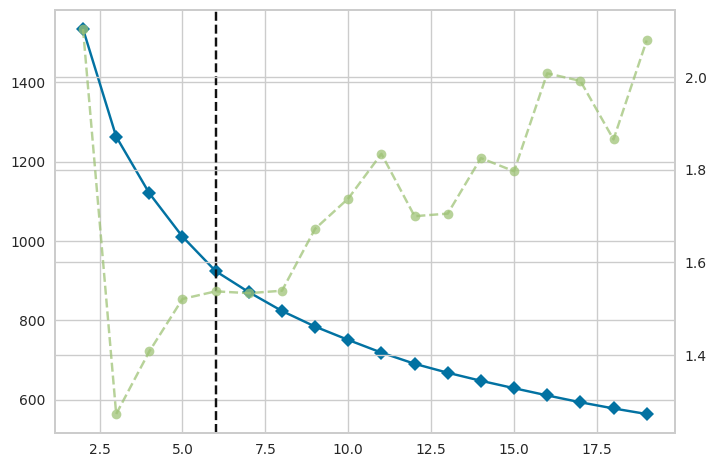

In [15]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2,20)).fit(model_df)

In [16]:
elbow.elbow_value_

6

<h1 style="color: #074973; font-weight: bold;text-align:center">Model</h1>

In [17]:
k_means = KMeans(n_clusters = elbow.elbow_value_, random_state = 42).fit(model_df)

In [18]:
k_means.cluster_centers_, k_means.inertia_, k_means.labels_

(array([[0.07802489, 0.08467666, 0.39641885, 0.37032625, 0.25695586,
         0.71564218],
        [0.03274778, 0.02646022, 0.32265035, 0.30728608, 0.88566184,
         0.74506569],
        [0.29548969, 0.08226294, 0.38572633, 0.5378936 , 0.46979836,
         0.7938473 ],
        [0.04161131, 0.03726384, 0.34830508, 0.32357615, 0.58901348,
         0.68821842],
        [0.2545189 , 0.04892237, 0.34446472, 0.50355719, 0.83549529,
         0.81493108],
        [0.06143296, 0.19227013, 0.50634669, 0.34078221, 0.78574459,
         0.78118067]]),
 923.9990398299258,
 array([4, 4, 4, ..., 0, 5, 1], dtype=int32))

In [19]:
cluster = k_means.labels_
final_df = df[num_cols]
final_df["segment"] = cluster
final_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,4.0,1.0,139.99,799.38,95,214,4
1,19.0,2.0,159.97,1853.58,105,1574,4
2,3.0,2.0,189.97,395.35,186,552,4
3,1.0,1.0,39.99,81.98,135,146,1
4,1.0,1.0,49.99,159.99,86,668,3


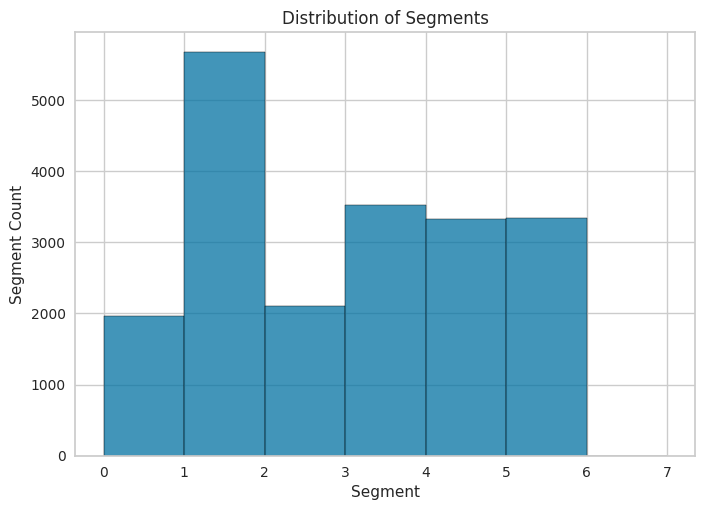

In [20]:
sns.histplot(cluster, bins=range(8), kde=False)
plt.xlabel('Segment')
plt.ylabel('Segment Count')
plt.title('Distribution of Segments')
plt.show();

In [21]:
final_df['segment'] = cluster
segment_summary = final_df.groupby('segment').describe().T
segment_summary

segment                                            0            1  \
order_num_total_ever_online       count  1961.000000  5671.000000   
                                  mean      2.114227     1.392700   
                                  std       1.441798     0.621550   
                                  min       1.000000     1.000000   
                                  25%       1.000000     1.000000   
                                  50%       2.000000     1.000000   
                                  75%       3.000000     2.000000   
                                  max      11.000000     4.000000   
order_num_total_ever_offline      count  1961.000000  5671.000000   
                                  mean      2.076492     1.266796   
                                  std       1.583481     0.484201   
                                  min       1.000000     1.000000   
                                  25%       1.000000     1.000000   
                                  50%       2.000000     1.000000   
                                  75%       3.000000     1.000000   
                                  max      14.000000     4.000000   
customer_value_total_ever_offline count  1961.000000  5671.000000   
                                  mean    292.470903   146.235338   
                                  std     275.956054    93.733429   
                                  min      12.990000    10.490000   
                                  25%     112.980000    79.990000   
                                  50%     209.980000   124.980000   
                                  75%     379.940000   190.955000   
                                  max    3425.140000   829.980000   
customer_value_total_ever_online  count  1961.000000  5671.000000   
                                  mean    366.780245   205.298461   
                                  std     301.541269   134.227297   
                                  min      23.990000    12.990000   
                                  25%     169.980000   101.980000   
                                  50%     289.130000   178.380000   
                                  75%     466.760000   275.980000   
                                  max    3444.080000  1519.170000   
recency                           count  1961.000000  5671.000000   
                                  mean     10.797042   225.749074   
                                  std       5.805048    79.566384   
                                  min       2.000000    79.000000   
                                  25%       6.000000   159.000000   
                                  50%      11.000000   208.000000   
                                  75%      14.000000   302.000000   
                                  max      29.000000   367.000000   
tenure                            count  1961.000000  5671.000000   
                                  mean    649.763896   707.883795   
                                  std     415.489105   418.045885   
                                  min       5.000000   127.000000   
                                  25%     450.000000   487.000000   
                                  50%     603.000000   614.000000   
                                  75%     783.000000   790.000000   
                                  max    2968.000000  3044.000000   

segment                                             2            3  \
order_num_total_ever_online       count   2108.000000  3529.000000   
                                  mean       8.257116     1.515727   
                                  std        8.302899     0.753559   
                                  min        2.000000     1.000000   
                                  25%        4.000000     1.000000   
                                  50%        6.000000     1.000000   
                                  75%        9.000000     2.000000   
                                  max      200.000000     

In [22]:
final_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,4.0,1.0,139.99,799.38,95,214,4
1,19.0,2.0,159.97,1853.58,105,1574,4
2,3.0,2.0,189.97,395.35,186,552,4
3,1.0,1.0,39.99,81.98,135,146,1
4,1.0,1.0,49.99,159.99,86,668,3


<h1 style="color: #074973; font-weight: bold;text-align:center">Hierarchical Cluster Analysis</h1>

In [23]:
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,0.198755,0.000000,0.344381,0.500774,0.720607,0.574022
1,0.499459,0.101181,0.362274,0.604762,0.741210,0.893422
2,0.150352,0.101181,0.385347,0.413806,0.859241,0.725548
3,0.000000,0.000000,0.177596,0.220302,0.793028,0.513041
4,0.000000,0.000000,0.207069,0.302315,0.700139,0.756090


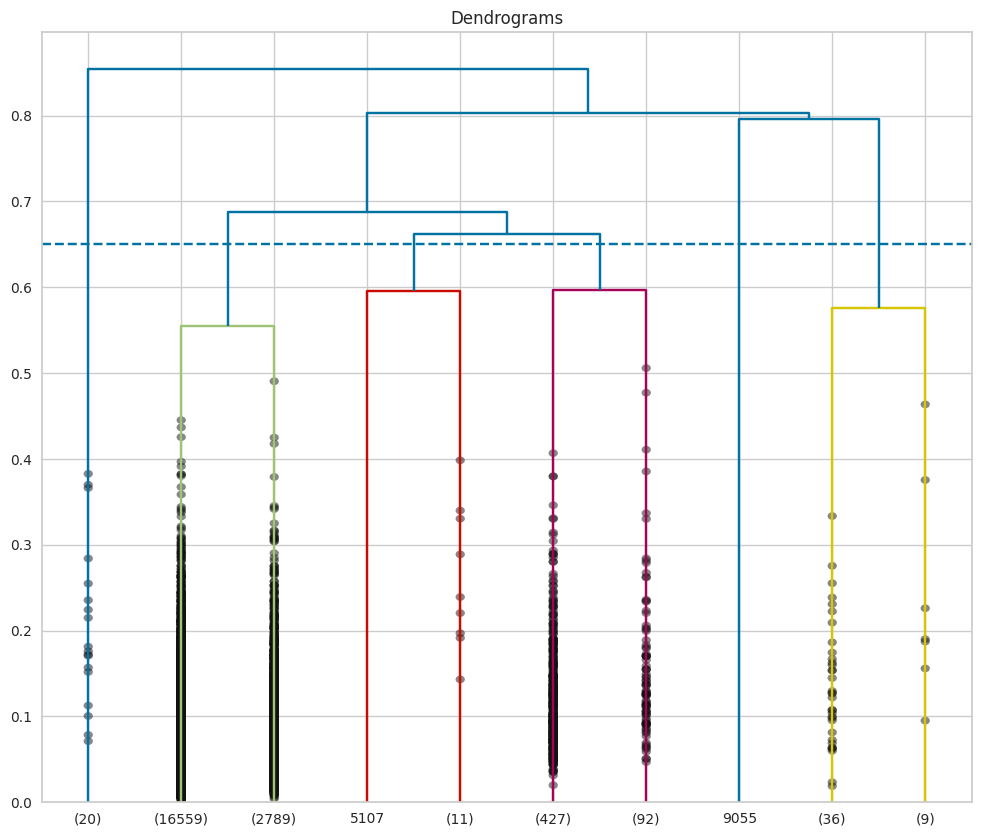

In [24]:
hc_average = linkage(model_df, 'average')

plt.figure(figsize=(12, 10))
plt.title("Dendrograms")
dend = dendrogram(hc_average,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.axhline(y=0.65, color='b', linestyle='--') 
plt.show();

In [25]:
hc = AgglomerativeClustering(n_clusters=5, linkage="average")
segments = hc.fit_predict(model_df)
model_df["hi_segment"] = segments
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,hi_segment
0,0.198755,0.000000,0.344381,0.500774,0.720607,0.574022,1
1,0.499459,0.101181,0.362274,0.604762,0.741210,0.893422,1
2,0.150352,0.101181,0.385347,0.413806,0.859241,0.725548,1
3,0.000000,0.000000,0.177596,0.220302,0.793028,0.513041,1
4,0.000000,0.000000,0.207069,0.302315,0.700139,0.756090,1


In [26]:
cluster_summary = model_df.groupby('hi_segment').describe().T
cluster_summary

hi_segment                                        0             1          2  \
order_num_total_ever_online       count  531.000000  19348.000000  45.000000   
                                  mean     0.395194      0.100650   0.067136   
                                  std      0.130817      0.117151   0.113024   
                                  min      0.087950      0.000000   0.000000   
                                  25%      0.300704      0.000000   0.000000   
                                  50%      0.388655      0.087950   0.000000   
                                  75%      0.476605      0.150352   0.087950   
                                  max      1.000000      0.737762   0.422092   
order_num_total_ever_offline      count  531.000000  19348.000000  45.000000   
                                  mean     0.135641      0.069273   0.014075   
                                  std      0.139085      0.089202   0.043776   
                                  min      0.000000      0.000000   0.000000   
                                  25%      0.000000      0.000000   0.000000   
                                  50%      0.101181      0.000000   0.000000   
                                  75%      0.228653      0.101181   0.000000   
                                  max      0.728108      0.561793   0.228653   
customer_value_total_ever_offline count  531.000000  19348.000000  45.000000   
                                  mean     0.422565      0.373844   0.381648   
                                  std      0.140239      0.113086   0.118071   
                                  min      0.050503      0.000000   0.073718   
                                  25%      0.334449      0.299333   0.299333   
                                  50%      0.422637      0.377996   0.370427   
                                  75%      0.505731      0.453661   0.455457   
                                  max      0.781461      0.806639   0.736668   
customer_value_total_ever_online  count  531.000000  19348.000000  45.000000   
                                  mean     0.602431      0.373078   0.372778   
                                  std      0.088259      0.115173   0.151691   
                                  min      0.322132      0.000000   0.154912   
                                  25%      0.548309      0.290212   0.257679   
                                  50%      0.600765      0.370761   0.340384   
                                  75%      0.656320      0.453977   0.428959   
                                  max      1.000000      0.836233   0.952030   
recency                           count  531.000000  19348.000000  45.000000   
                                  mean     0.345874      0.712938   0.270058   
                                  std      0.213348      0.217674   0.145359   
                                  min      0.000000      0.000000   0.106212   
                                  25%      0.176173      0.576485   0.144121   
                                  50%      0.320294      0.761739   0.228427   
                                  75%      0.498578      0.877333   0.320294   
                                  max      0.985977      1.000000   0.657883   
tenure                            count  531.000000  19348.000000  45.000000   
                                  mean     0.820863      0.754404   0.217098   
                                  std      0.096425      0.099464   0.105316   
                                  min      0.556708      0.278216   0.000000   
                                  25%      0.748103      0.714440   0.146965   
                                  50%      0.814516      0.751222   0.222350   
                                  75%      0.898089      0.791641   0.258140   
                                  max      1.000000      0.999685   0.439608   

hi_segment                                      3          4  
order_num_total_

In [27]:
final_df['hi_segment'] = model_df['hi_segment']
final_df.head(10)

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment,hi_segment
0,4.0,1.0,139.99,799.38,95,214,4,1
1,19.0,2.0,159.97,1853.58,105,1574,4,1
2,3.0,2.0,189.97,395.35,186,552,4,1
3,1.0,1.0,39.99,81.98,135,146,1,1
4,1.0,1.0,49.99,159.99,86,668,3,1
5,1.0,2.0,150.87,49.99,80,926,3,1
6,3.0,1.0,59.99,315.94,226,454,1,1
7,1.0,1.0,49.99,113.64,293,382,1,1
8,3.0,2.0,120.48,934.21,86,495,4,1
9,1.0,1.0,69.98,95.98,240,672,1,1
